# Demo: Roman CGI PSF models with WebbPSF

This tutorial will walk you through the basics of using the WebbPSF package to generate PSF models for the Roman CGI. If this is your first time using WebbPSF, it could be worthwhile to first go through the original WebbPSF tutorial notebook, hosted at https://github.com/spacetelescope/webbpsf/blob/master/notebooks/WebbPSF_tutorial.ipynb.

Current functionality is limited to the Shaped Pupil Coronagraph (SPC) observing modes, and these modes are only simulated with static, unaberrated wavefronts, without relay optics and without DM control. The design respresented here is an approximation to a baseline concept, and will be subject to change based on ongoing trades studies and technology development.

First, we set up the notebook to display plots inline, and to plot images with the origin in the lower left.

In [ ]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

## Load packages

In [ ]:
import os
os.environ['WEBBPSF_PATH'] = 'home/marken/GitHub/webbpsf/webbpsf_data/'
import webbpsf
from webbpsf import roman
import ipywidgets
from astropy.io import fits

WebbPSF produces various log messages while it works, using Python's built-in logging mechanism. In order to see them, we need to set up a log handler that will display them on the screen. This is done using the ``setup_logging`` function. 

In [ ]:
webbpsf.setup_logging()

We can also choose to save log outputs to a file, if that's desired.

## Shaped pupil coronagraph PSF

The list of supported observing modes is a private attribute of the CGI instrument subclass. If we instantiate a coronagraph without specifying a mode keyword, the init function will print the table and note the default settings.

In [ ]:
default_cgi = roman.CGI()

There are two shaped pupil coronagraphs implemented so far: 'CHARSPC' and 'DISKSPC' -- these are the atmospheric characterization and debris disk imaging modes of CGI, respectively. The filters choices for 'CHARSPC' are 'F660','F770', and 'F890' (18% bandwidth IFS filters centered at 660 nm, 770 nm, and 890 nm). The 'DISKSPC' operates with one filter, 'F721', centered at 721 nm with a 5% bandwidth imaging filter. All of these coronagraphs us the same Lyot stop.

Now let's make a new object specifying the characterization mode centered at wavelength 770 nm.

In [ ]:
char_spc = roman.CGI(mode='CHARSPC_F770')

We can use the ``display()`` method of the new optical system to show the masks that define the coronagraph, starting from the telescope pupil. 

In [ ]:
plt.figure(figsize=(6,9))
char_spc.display()

To simulate the PSF, we then call its ``calc_psf`` function.  Note the log output describes various details of the calculation as it proceeds. The returned result is a fits HDUList object containing both the image data and its associated metadata in the header. 

In [ ]:
plt.figure(figsize=(12,9))
mono_char_spc_psf = char_spc.calc_psf(nlambda=1, fov_arcsec=1.6, display=True)

In [ ]:
webbpsf.display_psf(mono_char_spc_psf,ext=1,vmin=1e-13, vmax=1e-10)

Note, in Poppy/WebbPSF the PSF intensity values are normalized to the sum of the intensity in the telescope pupil. Therefore, the values in the intensity colorbar are NOT contrast units. In the next example, we will show how to display the PSF result in contrast units.

## Integral field spectrograph PSF with the characterization SPC

In [ ]:
webbpsf.setup_logging('ERROR') # Reduce the verbosity

To approximate the PSF produced by the integral field spectrograph, we can form a cube of monochromatic PSFs computed at wavelengths spanning the bandpass:

In [ ]:
ifs_spc = roman.CGI()
ifs_spc.mode = 'CHARSPC_F890'

filter_fname = ifs_spc._filters[ifs_spc.filter].filename
filter_hdulist = fits.open(filter_fname)
wave_beg = (float(filter_hdulist[1].header.get('LAMBDA0')) - float(filter_hdulist[1].header.get('DELTALAM'))/2)
wave_end = (float(filter_hdulist[1].header.get('LAMBDA0')) + float(filter_hdulist[1].header.get('DELTALAM'))/2)
deltalam_ifs = float(filter_hdulist[1].header.get('LAMBDA0'))/70. # Assume spectral resolution R = 70
Nchan = (int(np.floor((wave_end - wave_beg)/deltalam_ifs))//2)*2 + 1 # Number of channels, forced to an odd integer
wavelens = np.linspace(wave_beg, wave_end, Nchan) * 1e-10 # all wavelengths to model, in meters

lamoD_asec = float(filter_hdulist[1].header.get('LAMBDA0'))*1e-10/(2*ifs_spc.PUPIL_RADIUS) * 180/np.pi * 3600
print("System diffraction resolution element scale (lambda_0/D) in arcsec: %.3f" % lamoD_asec)
print("IFS spectral parameters: %d channels of characteristic spectral width %.2f nm," % (Nchan,deltalam_ifs/10.))
print("ranging from %d nm to %d nm, centered on %d nm" % (wavelens[0]*1e9, wavelens[-1]*1e9, wavelens[Nchan//2]*1e9))
filter_hdulist.close()

In [ ]:
ifs_spc.options['source_offset_r'] = 0 # arcsec
ifs_spc.options['source_offset_theta'] = 0 # deg w.r.t. North

ifs_psf_onax = ifs_spc.calc_datacube(wavelens, fov_arcsec=1.64, oversample=4, display=False)
print("The resulting data cube has dimensions {} wavelengths x {} pixels x {} pixels".format\
      (ifs_psf_onax[1].data.shape[0], ifs_psf_onax[1].data.shape[1], ifs_psf_onax[1].data.shape[2]))

### Convert the PSF cube intensity values to units of contrast, using the off-axis PSF 

We can use the source offset option to propagate a plane wave through the transmitted region of the focal plane mask. This provides a close approximation for the peak of the target star PSF if we had not occulted it, which in turn determines the conversion factor to contrast units.

In [ ]:
ifs_spc.options['source_offset_r'] = 6*lamoD_asec # 6 lam/D in arcsec
ifs_spc.options['source_offset_theta'] = -90. # deg w.r.t. North

ifs_psf_offax = ifs_spc.calc_datacube(wavelens, fov_arcsec=1.64, oversample=4, display=False)
offax_peak_vec = np.max(np.max(ifs_psf_offax[1].data, axis=-1), axis=-1)
offax_peak_cube = np.tile(offax_peak_vec[:,np.newaxis,np.newaxis],
                          (1, ifs_psf_onax[1].data.shape[-2], ifs_psf_onax[1].data.shape[-1]))

ifs_psf_onax_contrast = ifs_psf_onax[1].data / offax_peak_cube

## Plot the polychromatic PSF cube of the IFS in contrast units. 

In [ ]:
def plt_ifs_psf_onax(wchan):
    plt.imshow(ifs_psf_onax_contrast[wchan-1], norm=matplotlib.colors.LogNorm(),
               vmin=3e-10, vmax=3e-8, cmap='gist_heat')
    plt.colorbar()
ipywidgets.interact(plt_ifs_psf_onax, wchan=(1,Nchan));

### Plot the off-axis PSF used for the contrast calibration

In [ ]:
def plt_ifs_psf_offax(wchan):
    plt.imshow(ifs_psf_offax[1].data[wchan-1], cmap='gist_heat');
    plt.colorbar()
ipywidgets.interact(plt_ifs_psf_offax, wchan=(1,len(wavelens)));

# Debris disk mode SPC

In [ ]:
diskcg = roman.CGI(mode='DISKSPC_F721')
diskcg.options['source_offset_r'] = 0 # arcsec
diskcg.options['source_offset_theta'] = 0 # deg w.r.t. North

In [ ]:
diskpsf_onax = diskcg.calc_psf(fov_arcsec=2.2, display=False)

In [ ]:
webbpsf.display_psf(diskpsf_onax,ext=1,vmin=1e-11, vmax=1e-9)

## Off-axis PSF

In [ ]:
diskcg.options['source_offset_r'] = 0.6 # arcsec
diskcg.options['source_offset_theta'] = -45. # deg w.r.t. North

In [ ]:
plt.figure(figsize=(12,9))
diskpsf_offax = diskcg.calc_psf(fov_arcsec=2.2, display=True)
diskpsf_offax_peak = diskpsf_offax[1].data.max()

In [ ]:
# Form a simple bright companion scene by summing the on-axis and off-axis PSF, the latter scaled by 1E-7.
comb_img = (diskpsf_onax[1].data + diskpsf_offax[1].data*1e-7)/diskpsf_offax_peak # Contrast units
comb_hdu = fits.PrimaryHDU(comb_img, header=diskpsf_onax[1].header)
comb_hdulist = fits.HDUList([comb_hdu])

### Plot composite disk SPC PSF (on-axis + off-axis@1E-7 contrast) in units of contrast 

In [ ]:
webbpsf.display_psf(comb_hdulist,vmin=1e-9, vmax=3e-8)

#TEST AREA

In [26]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

import os
os.environ['WEBBPSF_PATH'] = '../webbpsf_data/'
#os.environ['WEBBPSF_PATH'] = '/home/marken/GitHub/webbpsf/webbpsf_data/'
import webbpsf
from webbpsf import roman
import ipywidgets
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib import colors, ticker, cm

webbpsf.setup_logging()
DMon = roman.CGI(mode='CHARSPC_F770')
DMoff = roman.CGI(mode='CHARSPC_F770')

Populating the interactive namespace from numpy and matplotlib
WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.
[webbpsf] Set the following optical configuration:
[webbpsf] camera = IFS, filter = F770, apodizer = CHARSPC, fpm = CHARSPC_F770_BOWTIE, lyotstop = LS30D88
[webbpsf] Set the following optical configuration:
[webbpsf] camera = IFS, filter = F770, apodizer = CHARSPC, fpm = CHARSPC_F770_BOWTIE, lyotstop = LS30D88


[  poppy] Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
[  poppy] CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: Roman+CGI
[  poppy] Roman Entrance Pupil: Loaded amplitude transmission from ../webbpsf_data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: Roman Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] CHARSPC: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/CHARSPC_SP_256pix.fits.gz
[  poppy] Added pupil plane: CHARSPC
[  poppy] Added pupil plane: DM
[  poppy] CHARSPC_F770_BOWTIE: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz
[  poppy] Added image plane: CHARSPC_F770_BOWTIE
[  poppy] LS30D88: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/SPC_LS_30D88_256pix.fits.gz
[  poppy] Added pupil plane: LS30D88
[  poppy] Initialized OpticalSystem: unnamed system
[  poppy] Added detector with pixelscale=0.025 and oversampling=2: CGI detector
[  poppy] Displaying 

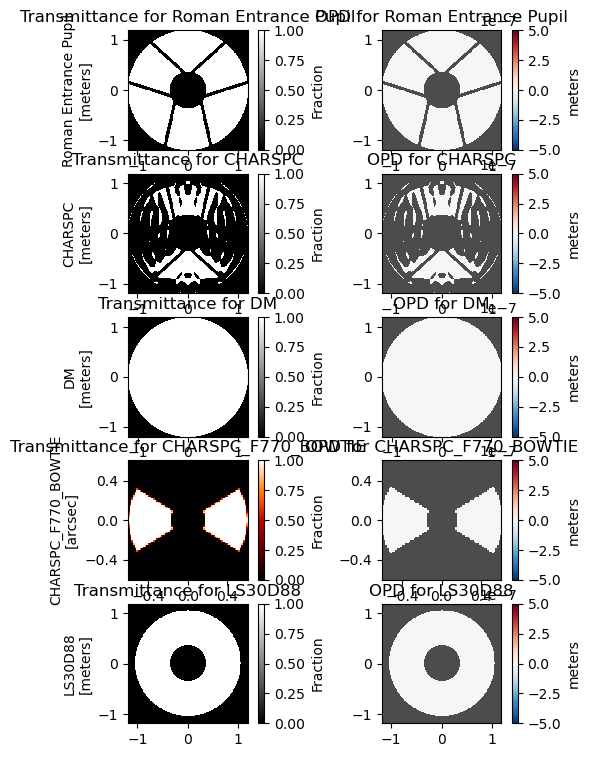

In [27]:
plt.figure(figsize=(6,9))
DMoff.display()

[  poppy] Computing opd for DM sampled onto 512 pixel grid with pixelscale 0.0046875 m / pix


<AxesSubplot:title={'center':'OPD for DM'}, ylabel='[meters]'>

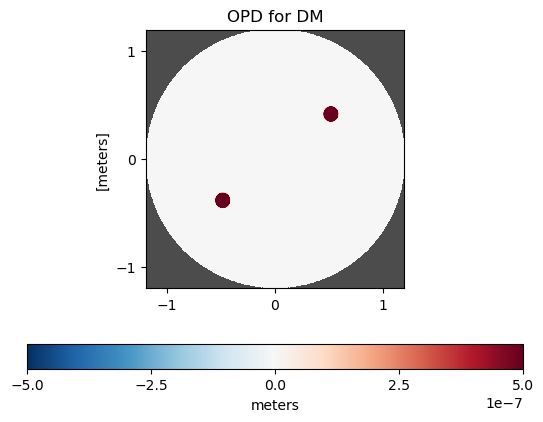

In [28]:
DMon.dm1.set_actuator(4, 8, 1)
DMon.dm1.set_actuator(44, 40, 1)
DMon.dm1.display()

[  poppy] Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
[  poppy] CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: Roman+CGI
[  poppy] Roman Entrance Pupil: Loaded amplitude transmission from ../webbpsf_data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: Roman Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] CHARSPC: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/CHARSPC_SP_256pix.fits.gz
[  poppy] Added pupil plane: CHARSPC
[  poppy] Added pupil plane: DM
[  poppy] CHARSPC_F770_BOWTIE: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz
[  poppy] Added image plane: CHARSPC_F770_BOWTIE
[  poppy] LS30D88: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/SPC_LS_30D88_256pix.fits.gz
[  poppy] Added pupil plane: LS30D88
[  poppy] Initialized OpticalSystem: unnamed system
[  poppy] Added detector with pixelscale=0.025 and oversampling=2: CGI detector
[  poppy] Displaying 

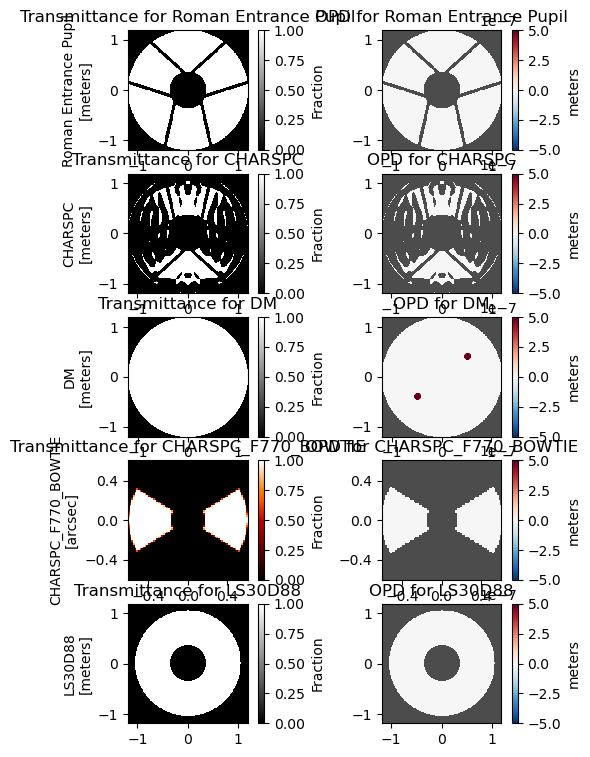

In [29]:
plt.figure(figsize=(6,9))
DMon.display()

In [30]:
def circle_mask(im , rad):
    """Create a circular aperture centered on (xc, yc) with radius rcirc."""
    xc = len(im)/2
    yc = len(im)/2
    x, y = np.shape(im)
    newy, newx = np.mgrid[:y,:x]
    circ = (newx-xc)**2 + (newy-yc)**2 < rad**2
    return circ.astype('float')

def section(im , angle):
    x, y = np.shape(im)
    xc = len(im)/2
    yc = len(im)/2
    newy, newx = np.mgrid[:y,:x]
    section = np.abs((newy-yc)/(newx-xc)) < np.arctan(angle)
    
    return section.astype('float')

In [33]:
def SPC_dark_hole(PSF_DMon_raw, PSF_DMoff_raw, display=True):
    PSF_DMon_fit = PSF_DMon_raw.calc_psf(nlambda=1, fov_arcsec=1.6)
    PSF_DMoff_fit = PSF_DMoff_raw.calc_psf(nlambda=1, fov_arcsec=1.6)
    
    #Get some header useful data #TODO get variable more higher    
    header = PSF_DMon_fit[0].header
    npix = header[3]
    pix_scale = header[11]
    lambdaD_scale = header[8]
    lambdaD_pix_scale = lambdaD_scale /pix_scale
    
    PSF_DMon = PSF_DMon_fit[0].data
    PSF_DMoff = PSF_DMoff_fit[0].data

    #Generate an sectionnal annulus mask
    IWA = circle_mask(PSF_DMon, 3*lambdaD_pix_scale)
    OWA = circle_mask(PSF_DMon, 9*lambdaD_pix_scale)
    WA = OWA - IWA
    WA *= section(PSF_DMoff, 50*np.pi/180)

    #Compute instrumental contrast
    contrast = PSF_DMon*WA
    norm = np.max(WA*PSF_DMoff)
    contrast_norm = (contrast/norm)
    
    if(display == True):
        scale = pix_scale * int(npix/2)
        plt.imshow(contrast_norm,  norm = LogNorm(), cmap = 'inferno', extent=[-scale,scale,-scale,scale])
        plt.xlabel('arcsec')
        plt.ylabel('arcsec')
        plt.colorbar()
        
    return np.mean(contrast_norm[np.where(contrast_norm!=0)])

[  poppy] Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
[  poppy] CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


[  poppy] PSF calc using fov_arcsec = 1.600000, oversample = 4, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: Roman+CGI
[  poppy] Roman Entrance Pupil: Loaded amplitude transmission from ../webbpsf_data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: Roman Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] CHARSPC: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/CHARSPC_SP_256pix.fits.gz
[  poppy] Added pupil plane: CHARSPC
[  poppy] Added pupil plane: DM
[  poppy] CHARSPC_F770_BOWTIE: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz
[  poppy] Added image plane: CHARSPC_F770_BOWTIE
[  poppy] LS30D88: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/SPC_LS_30D88_256pix.fits.gz
[  poppy] Added pupil plane: LS30D88
[  poppy] Initialized OpticalSystem: unnamed system
[  poppy] A

[  poppy] Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
[  poppy] CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


[  poppy] PSF calc using fov_arcsec = 1.600000, oversample = 4, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: Roman+CGI
[  poppy] Roman Entrance Pupil: Loaded amplitude transmission from ../webbpsf_data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: Roman Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] CHARSPC: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/CHARSPC_SP_256pix.fits.gz
[  poppy] Added pupil plane: CHARSPC
[  poppy] Added pupil plane: DM
[  poppy] CHARSPC_F770_BOWTIE: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz
[  poppy] Added image plane: CHARSPC_F770_BOWTIE
[  poppy] LS30D88: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/SPC_LS_30D88_256pix.fits.gz
[  poppy] Added pupil plane: LS30D88
[  poppy] Initialized OpticalSystem: unnamed system
[  poppy] A

<ipython-input-30-d4ef25a3010f>:15: RuntimeWarning: divide by zero encountered in true_divide
  section = np.abs((newy-yc)/(newx-xc)) < np.arctan(angle)
<ipython-input-30-d4ef25a3010f>:15: RuntimeWarning: invalid value encountered in true_divide
  section = np.abs((newy-yc)/(newx-xc)) < np.arctan(angle)


505.30452867040555

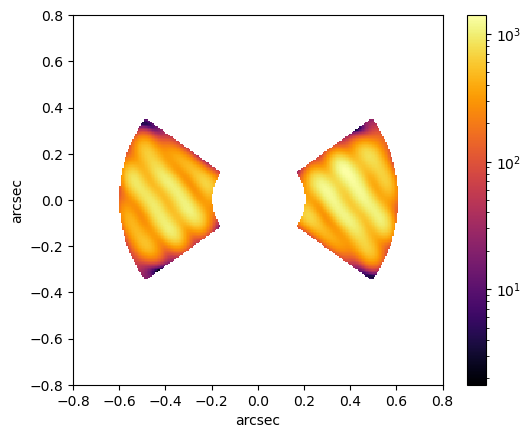

In [34]:
SPC_dark_hole(DMon , DMoff)

In [11]:
PSF_DMon_fit = DMon.calc_psf(nlambda=1, fov_arcsec=1.6)
header = PSF_DMon_fit[0].header
header

[  poppy] Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
[  poppy] CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


[  poppy] PSF calc using fov_arcsec = 1.600000, oversample = 4, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: Roman+CGI
[  poppy] Roman Entrance Pupil: Loaded amplitude transmission from ../webbpsf_data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: Roman Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] CHARSPC: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/CHARSPC_SP_256pix.fits.gz
[  poppy] Added pupil plane: CHARSPC
[  poppy] Added pupil plane: DM
[  poppy] CHARSPC_F770_BOWTIE: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz
[  poppy] Added image plane: CHARSPC_F770_BOWTIE
[  poppy] LS30D88: Loaded amplitude transmission from ../webbpsf_data/CGI/optics/SPC_LS_30D88_256pix.fits.gz
[  poppy] Added pupil plane: LS30D88
[  poppy] Initialized OpticalSystem: unnamed system
[  poppy] A

[astropy] VerifyWarning: Card is too long, comment will be truncated.


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN =              7.7E-07 / Weighted mean wavelength in meters             
DIFFLMT =  0.06701430413935199 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    4 / Oversampling factor for FFTs in computation    
DET_SAMP=                    4 / Oversampling factor for MFT to detector plane  
PIXELSCL=              0.00625 / Scale in arcsec/pix (after oversampling)       
FOV     =                  1